In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgn
%matplotlib inline

In [10]:
data_directory = "Downloads"
raw= pd.read_csv(f"{data_directory}/S1Data.csv")

In [11]:
raw

,TIME,Event,Gender,Smoking,Diabetes,BP,Anaemia,Age,Ejection.Fraction,Sodium,Creatinine,Pletelets,CPK
0,97,0,0,0,0,0,1,43.0,50,135,1.30,237000.00,358
1,180,0,1,1,1,0,1,73.0,30,142,1.18,160000.00,231
2,31,1,1,1,0,1,0,70.0,20,134,1.83,263358.03,582
3,87,0,1,0,0,0,1,65.0,25,141,1.10,298000.00,305
4,113,0,1,0,0,0,0,64.0,60,137,1.00,242000.00,1610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,250,0,0,0,1,0,0,45.0,55,132,1.00,543000.00,582
295,244,0,0,0,1,0,0,51.0,40,134,0.90,221000.00,582
296,14,1,1,0,0,0,0,45.0,14,127,0.80,166000.00,582
297,80,0,1,0,1,0,0,60.0,45,133,1.00,297000.00,897


In [13]:
raw.head()

,TIME,Event,Gender,Smoking,Diabetes,BP,Anaemia,Age,Ejection.Fraction,Sodium,Creatinine,Pletelets,CPK
0,97,0,0,0,0,0,1,43.0,50,135,1.30,237000.00,358
1,180,0,1,1,1,0,1,73.0,30,142,1.18,160000.00,231
2,31,1,1,1,0,1,0,70.0,20,134,1.83,263358.03,582
3,87,0,1,0,0,0,1,65.0,25,141,1.10,298000.00,305
4,113,0,1,0,0,0,0,64.0,60,137,1.00,242000.00,1610


In [14]:
raw.shape

(299, 13)

In [16]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TIME               299 non-null    int64  
 1   Event              299 non-null    int64  
 2   Gender             299 non-null    int64  
 3   Smoking            299 non-null    int64  
 4   Diabetes           299 non-null    int64  
 5   BP                 299 non-null    int64  
 6   Anaemia            299 non-null    int64  
 7   Age                299 non-null    float64
 8   Ejection.Fraction  299 non-null    int64  
 9   Sodium             299 non-null    int64  
 10  Creatinine         299 non-null    float64
 11  Pletelets          299 non-null    float64
 12  CPK                299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<AxesSubplot:>

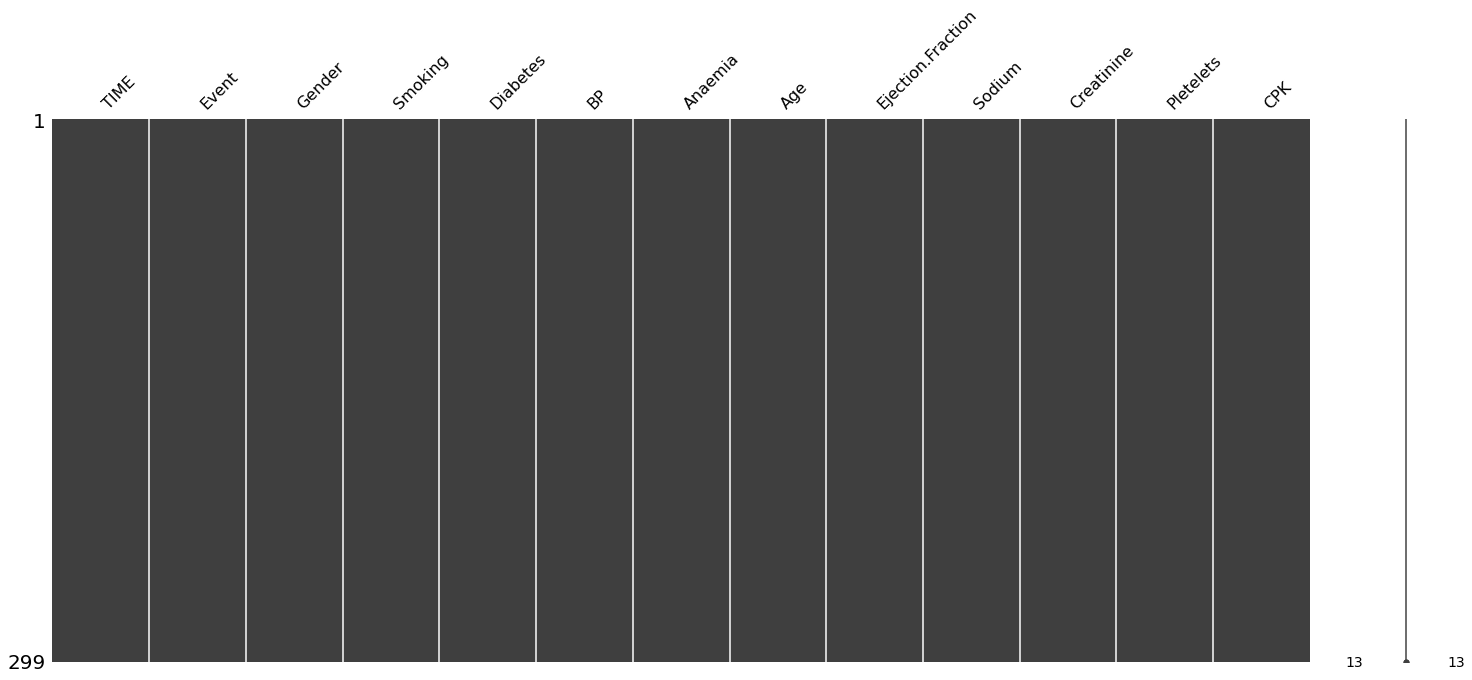

In [17]:
msgn.matrix(raw)

With a good idea of our data, lets look at some of the features between the patient that died during the follow-up period(1) or not (0)

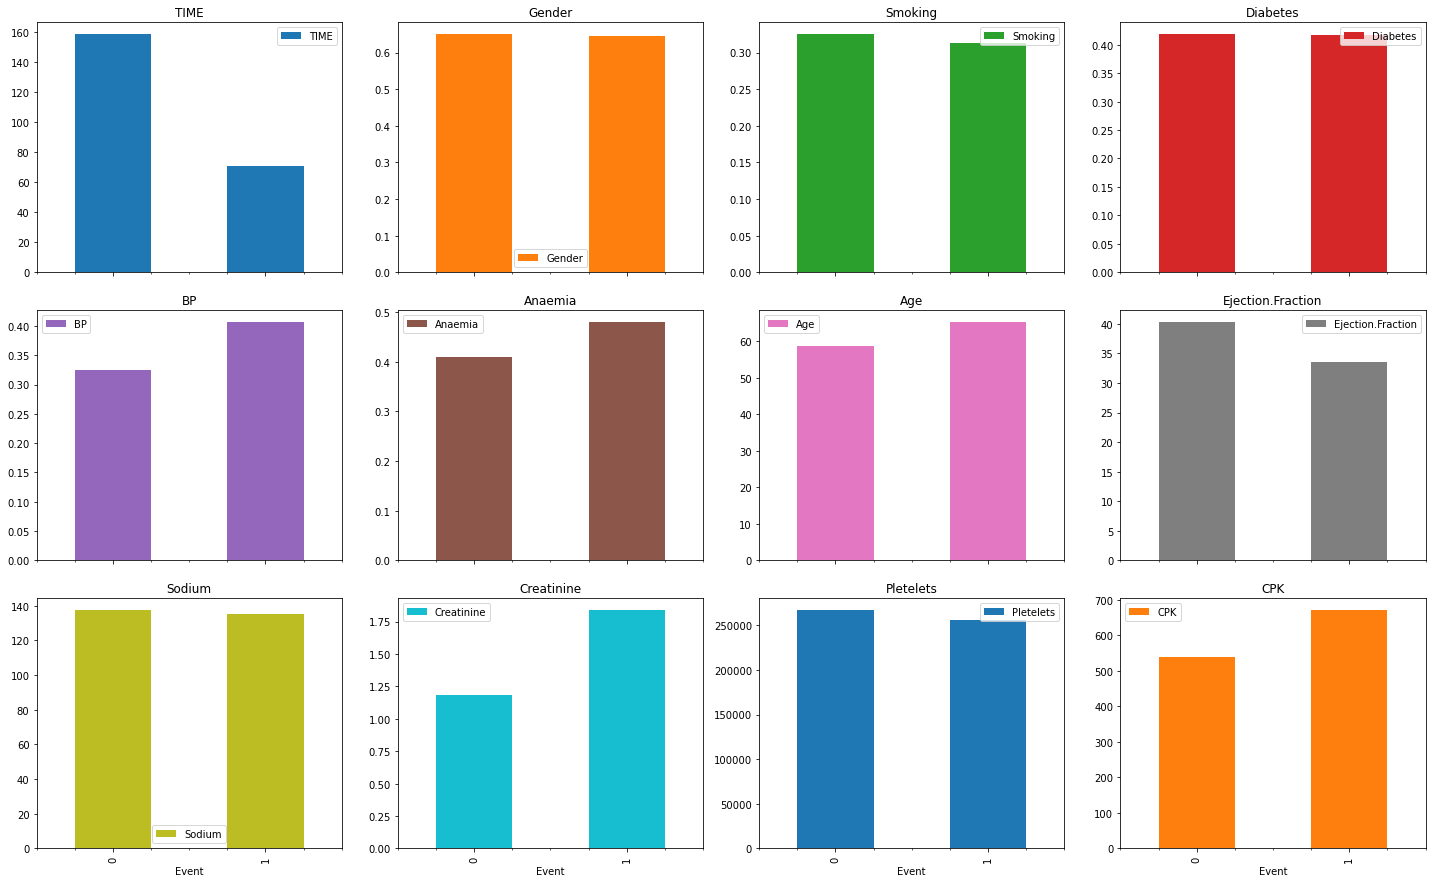

In [19]:
#Looking at mean attributes of decesead 

(raw
 .groupby('Event')
 .mean()
 .plot(kind='bar', figsize=(20,20), subplots=True, layout=(5,4), sharex=True)
)
plt.tight_layout()

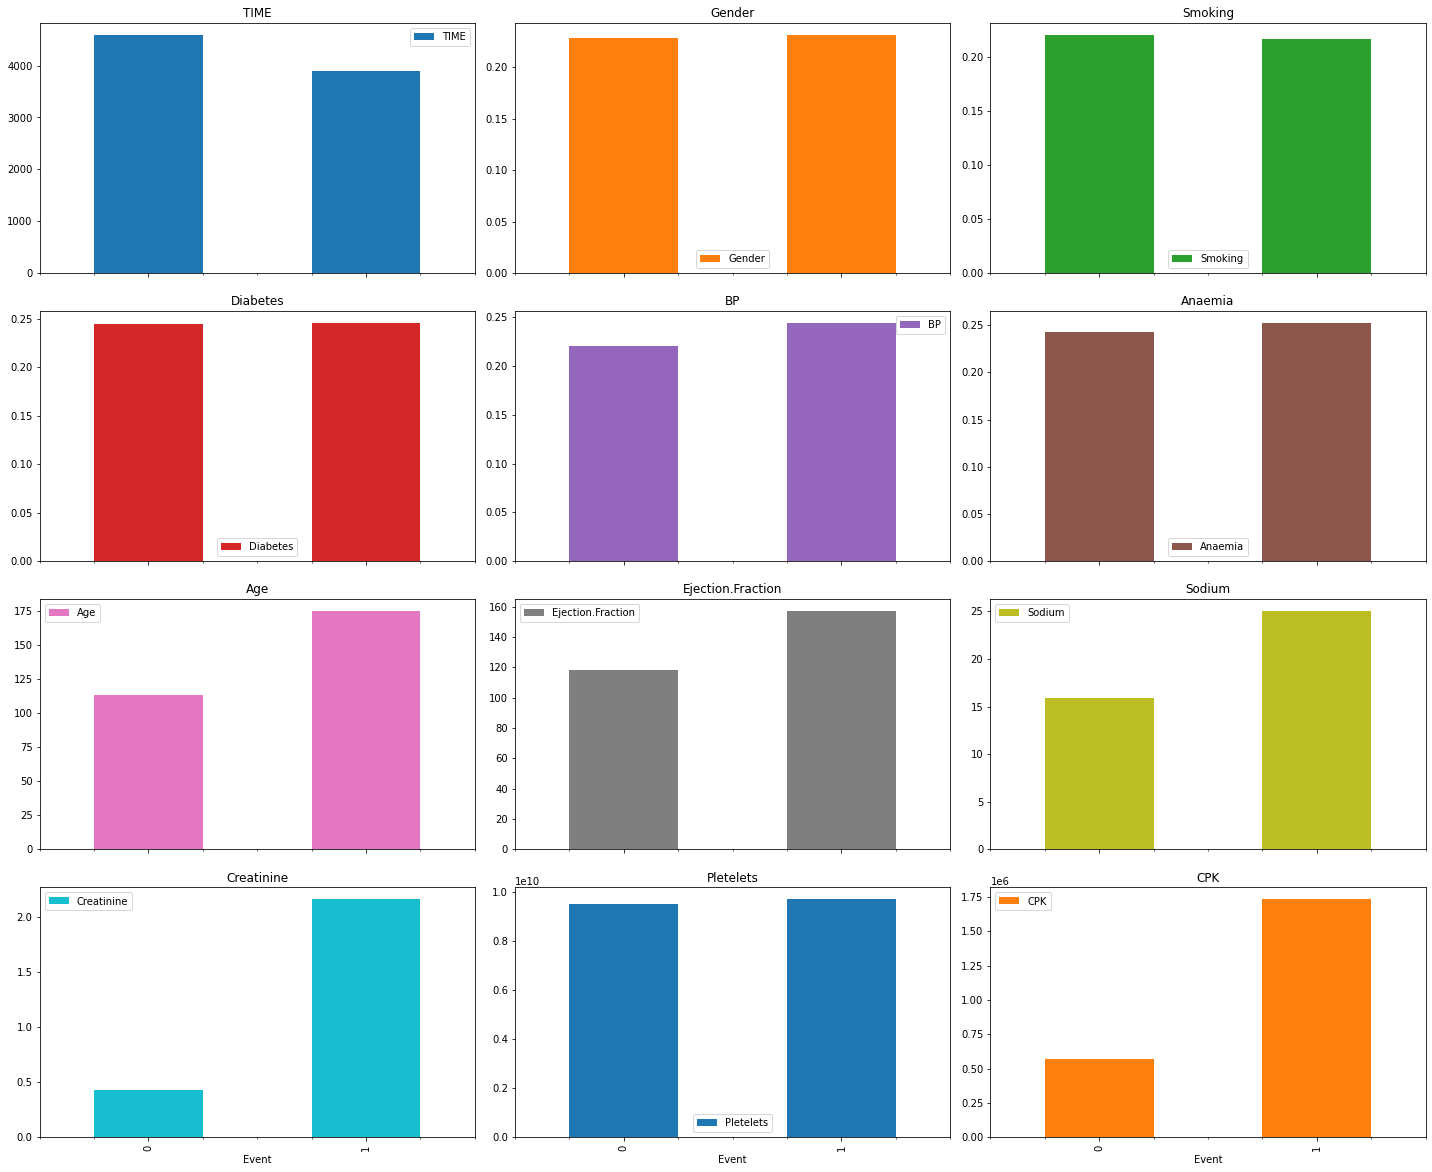

In [21]:
#Looking at the unbiased variance of the population

(raw
 .groupby('Event')
 .var()
 .plot(kind='bar', figsize=(20,20), subplots=True, layout=(5,3), sharex=True)
)
plt.tight_layout()

<AxesSubplot:>

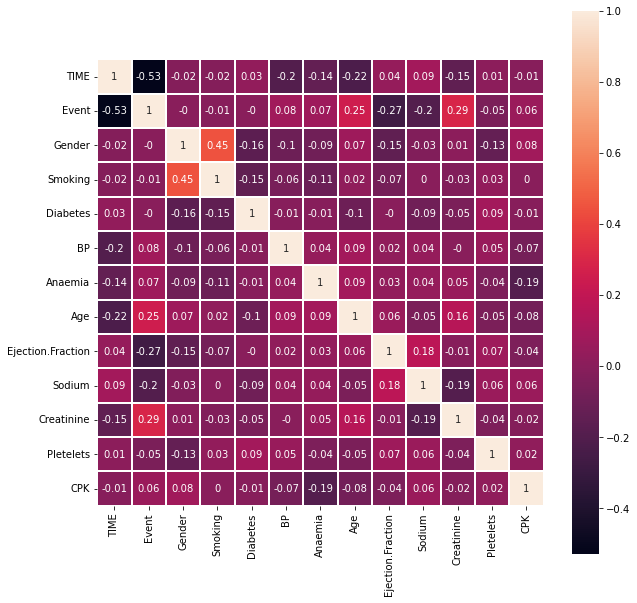

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(raw.corr().round(2), linewidths=.01,  annot=True, square=True)

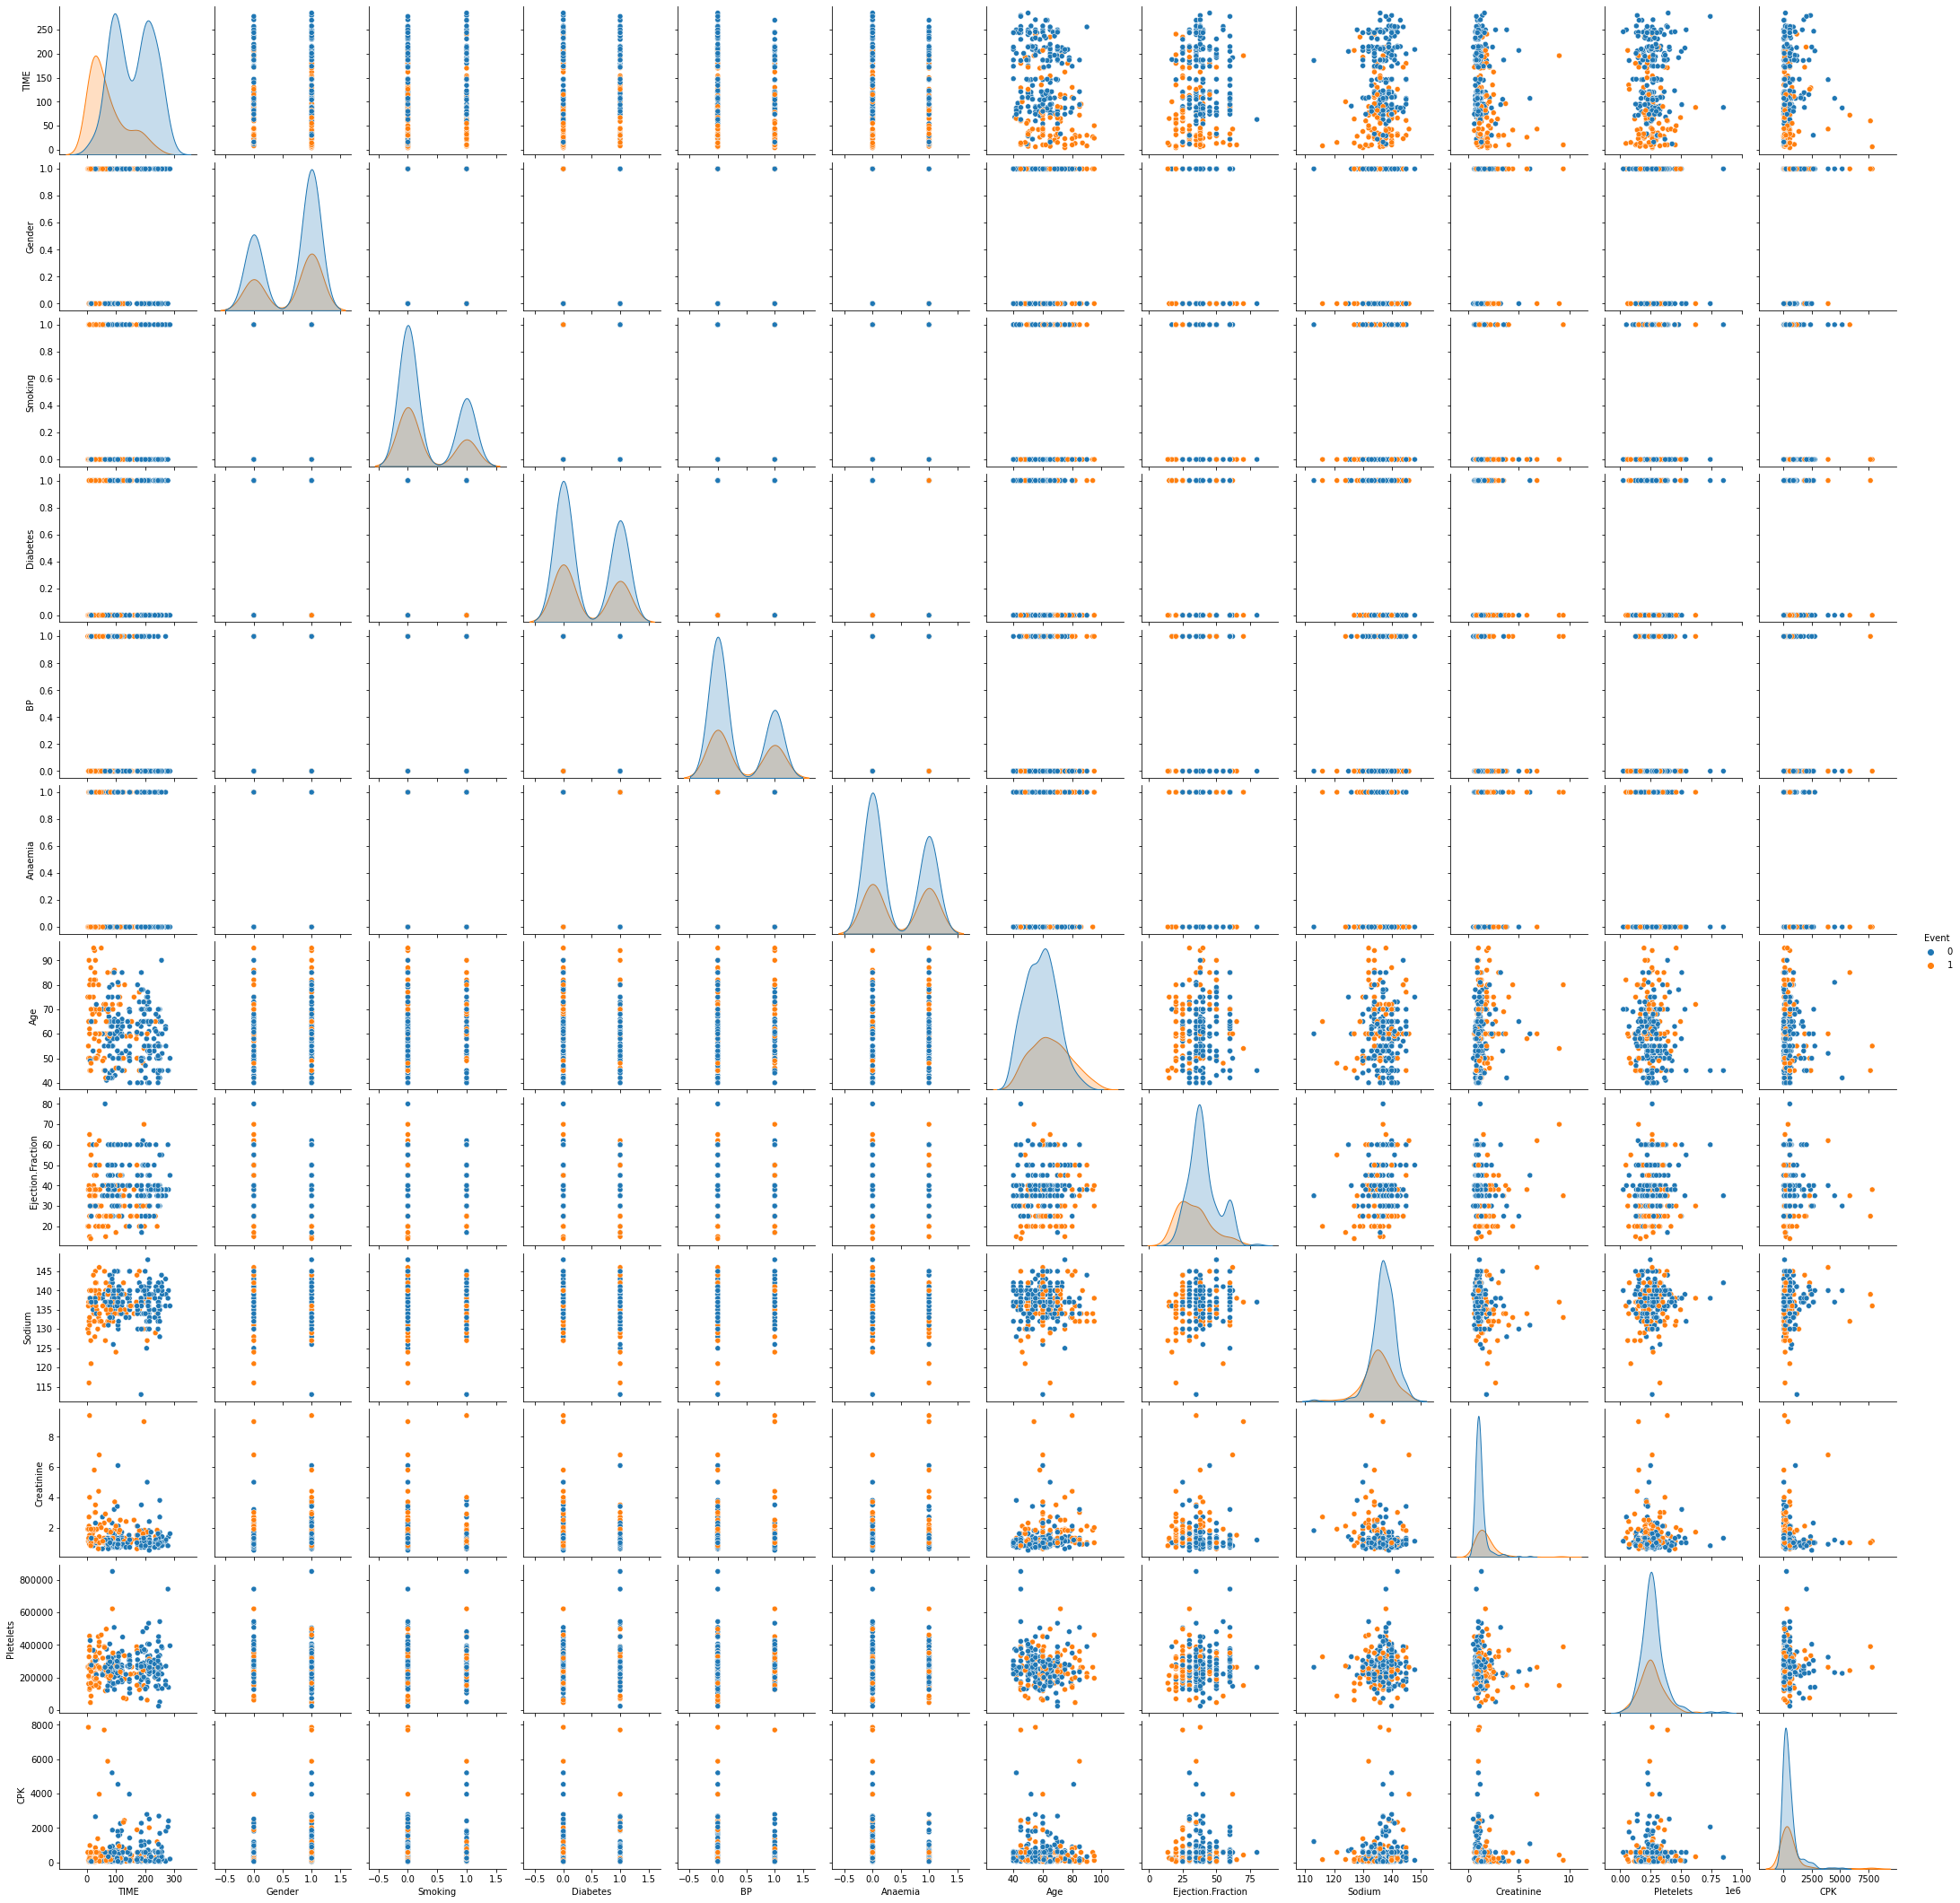

In [23]:
sns.pairplot(raw, hue='Event')

# Model set up

In [24]:
y=raw['Event']
feature_matrix=raw.drop(['Event'], axis=1)
X=pd.get_dummies(feature_matrix, drop_first=True, dummy_na=True)
X.shape

(299, 12)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y.value_counts(normalize=True)

0    0.67893
1    0.32107
Name: Event, dtype: float64

Our baseline is 32%. I think we can try to do better than that.

In [31]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler, QuantileTransformer, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

dtc=DecisionTreeClassifier()
sc=StandardScaler()
X_scaled=pd.DataFrame(data=sc.fit_transform(X), columns=X.columns)

0.7666666666666667


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

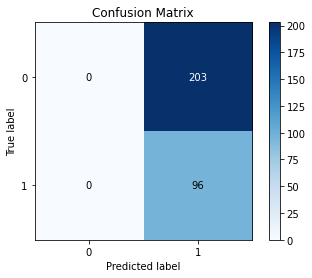

In [32]:
from scikitplot.metrics import plot_confusion_matrix
dtc.fit(X_train, y_train)
print(dtc.score(X_test, y_test))
y_pred=dtc.predict(X_scaled)
plot_confusion_matrix(y,y_pred)

##### Over/undersampling due to imbalance

In [33]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler


In [34]:
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline

In [35]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.748


I didn't end up using the over/undersampling and decided to take another route to balance out the data while also lowering the false negatives. I kept it for the F1 score and good practice!

In [36]:
feature_importance=pd.DataFrame(dtc.feature_importances_,
                               index=X_train.columns,
                               columns=['importance']).sort_values('importance')

In [37]:
feature_importance

,importance
Gender,0.000000
Smoking,0.000000
Diabetes,0.006940
Anaemia,0.012954
BP,0.017258
Ejection.Fraction,0.048927
Age,0.056766
Pletelets,0.057251
Creatinine,0.087625
Sodium,0.103817


Starting with a baseline accuracy of 32%, the model gives us an accuracy of 75%, well above baseline. We've also extracted the important features including Time (Follow-up period), CPK (Level of the CPK enzyme in the blood in mcg/L), and creatine levels. 

Now we can try to fine tune our model to lower the false positives

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

model = Pipeline([
    ('vt', VarianceThreshold(.1)),
    ('mm', MinMaxScaler()),
    ('model', RandomForestClassifier(n_estimators=200))
])

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(f'Accuracy {round(score*100, 1)}%')

Accuracy 86.7%


In [39]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = dict(
    vt__threshold = np.linspace(0,.5, 3),
    model__max_depth = [1,2,4,8],
    model__min_samples_split = [4,8,16]
)

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=1)

In [40]:
grid_search.fit(X_train.head(), y_train.head())

C:\Users\jgorgy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0.1)),
                                       ('mm', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_estimators=200))]),
             n_jobs=1,
             param_grid={'model__max_depth': [1, 2, 4, 8],
                         'model__min_samples_split': [4, 8, 16],
                         'vt__threshold': array([0.  , 0.25, 0.5 ])})

In [41]:
best_parameters=pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score').tail(5)['params'].values
best_parameters
                                                                  

array([{'model__max_depth': 1, 'model__min_samples_split': 8, 'vt__threshold': 0.0},
       {'model__max_depth': 1, 'model__min_samples_split': 4, 'vt__threshold': 0.5},
       {'model__max_depth': 1, 'model__min_samples_split': 4, 'vt__threshold': 0.25},
       {'model__max_depth': 4, 'model__min_samples_split': 4, 'vt__threshold': 0.25},
       {'model__max_depth': 8, 'model__min_samples_split': 16, 'vt__threshold': 0.5}],
      dtype=object)

Accuracy 76.3%


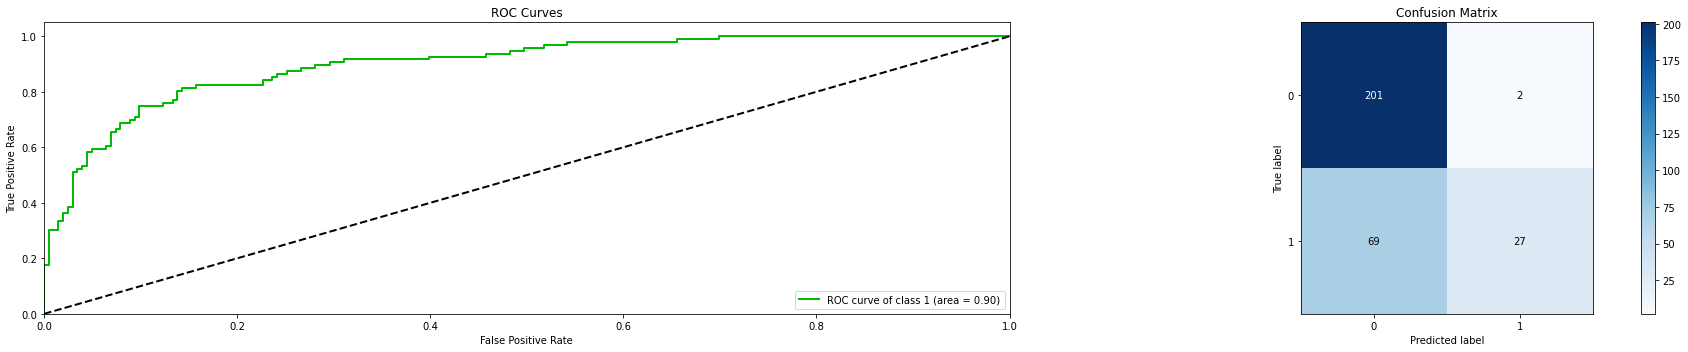

In [42]:
from sklearn.metrics import accuracy_score
from scikitplot.metrics import plot_roc, plot_precision_recall

model.set_params(**best_parameters[-3])

y_pred=cross_val_predict(model,X_scaled,y, method='predict', cv=5)
y_pred_proba=cross_val_predict(model, X_scaled,y, method='predict_proba', cv=5)

print(f'Accuracy {round(accuracy_score(y, y_pred)*100, 1)}%')

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(25,5)


plot_roc(y, y_pred_proba, plot_micro=False, plot_macro=False, classes_to_plot=1, ax=axes[0])
plot_confusion_matrix(y, y_pred, ax=axes[1])

plt.tight_layout()

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85       203
           1       0.93      0.28      0.43        96

    accuracy                           0.76       299
   macro avg       0.84      0.64      0.64       299
weighted avg       0.80      0.76      0.72       299



In [44]:
thresh = .3
print(classification_report(y, y_pred_proba[:, 1]>thresh))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84       203
           1       0.63      0.83      0.72        96

    accuracy                           0.79       299
   macro avg       0.77      0.80      0.78       299
weighted avg       0.82      0.79      0.80       299

